In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import glob
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers


# Data Processing

In [3]:
#Define the shape of the images and the batch size
image_size = (500, 500)
batch_size = 32

In [4]:
#Set the paths for the train and validation directories
train_dir = pathlib.Path('Data/train')
val_dir = pathlib.Path('Data/valid')

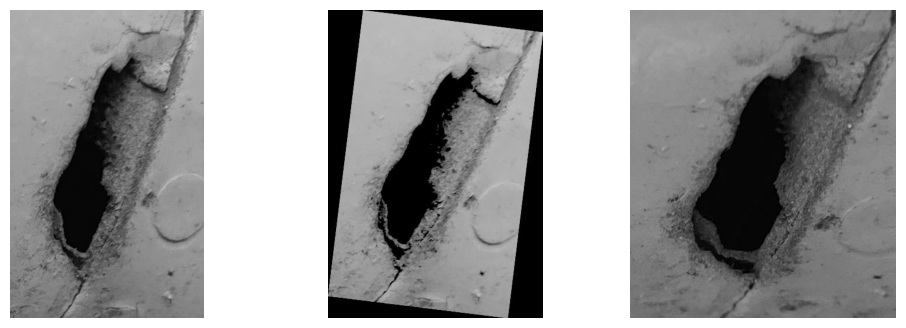

In [5]:
#Printing a few examples from the training set
cracks = list(train_dir.glob('crack/*'))

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i in range(3):
    image = Image.open(str(cracks[i]))
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [6]:
#Create train and validation datasets
train_ds = image_dataset_from_directory(
    train_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
    shuffle=True
)

Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


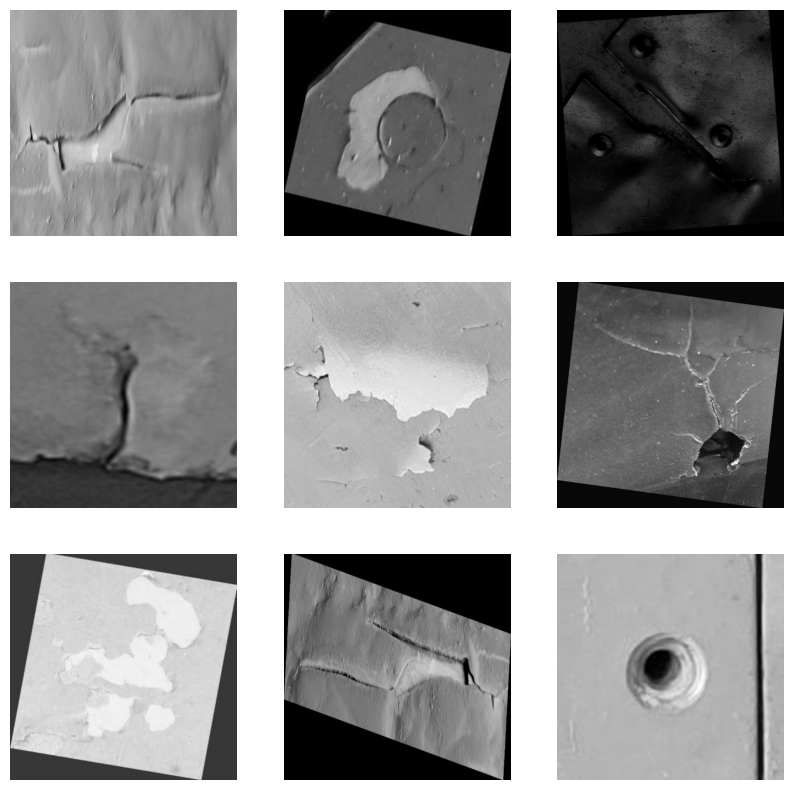

In [7]:
#Visualizing images from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
#Performance tuning the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
#Define rescale layer to be used as part of the model

rescale = tf.keras.Sequential([
    keras.layers.Rescaling(1./255),
])

In [10]:
#Data agmentation layers for the training set only

data_augmentation = keras.models.Sequential([
    keras.layers.RandomZoom(0.1), 
    keras.layers.RandomRotation(0.2)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [14]:
#Building the first model

model = keras.models.Sequential([
    rescale,
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, 'softmax')
])

model.build((None, 500, 500, 3))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 500, 500, 16)      1216      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 250, 250, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)     

In [ ]:
#Complile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
)

In [17]:
#Define checkpoint and early stopping callbacks

checkpoint_cb = keras.callbacks.ModelCheckpoint("current_model.h5")

early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [checkpoint_cb, early_stop_cb]


In [ ]:
#Fitting and training the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
61/61 [==============================] - 149s 2s/step - loss: 1.2029 - accuracy: 0.3744 - val_loss: 1.0349 - val_accuracy: 0.4014
Epoch 2/100
61/61 [==============================] - 107s 2s/step - loss: 0.9466 - accuracy: 0.5180 - val_loss: 0.7714 - val_accuracy: 0.6589
Epoch 3/100
38/61 [=================>............] - ETA: 36s - loss: 0.7734 - accuracy: 0.6517

KeyboardInterrupt: 

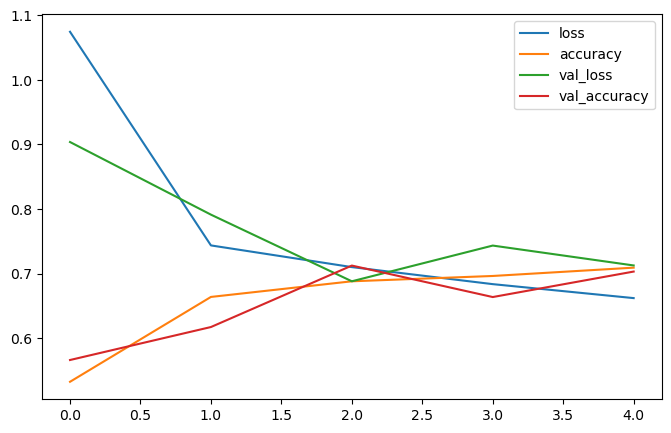

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [ ]:
#Building a second model with GAP() instead of flattten

model = keras.models.Sequential([
    rescale,
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, 'softmax')
])

model.build((None, 500, 500, 3))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 500, 500, 16)      1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 250, 250, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)     

In [15]:
#Complile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
)

In [18]:
#Fitting and training the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
61/61 [==============================] - 108s 2s/step - loss: 1.1361 - accuracy: 0.3512 - val_loss: 1.0798 - val_accuracy: 0.4664
Epoch 2/100
61/61 [==============================] - 102s 2s/step - loss: 1.0708 - accuracy: 0.4475 - val_loss: 1.0313 - val_accuracy: 0.6566
Epoch 3/100
61/61 [==============================] - 97s 2s/step - loss: 1.0420 - accuracy: 0.5211 - val_loss: 1.0140 - val_accuracy: 0.6218
Epoch 4/100
61/61 [==============================] - 99s 2s/step - loss: 1.0152 - accuracy: 0.5294 - val_loss: 0.9860 - val_accuracy: 0.6288
Epoch 5/100
61/61 [==============================] - 98s 2s/step - loss: 0.9803 - accuracy: 0.5448 - val_loss: 0.9728 - val_accuracy: 0.6148
Epoch 6/100
61/61 [==============================] - 98s 2s/step - loss: 0.9402 - accuracy: 0.5736 - val_loss: 1.0169 - val_accuracy: 0.4687
Epoch 7/100
61/61 [==============================] - 97s 2s/step - loss: 0.9203 - accuracy: 0.5623 - val_loss: 0.9258 - val_accuracy: 0.6798
Epoch 8/100

In [ ]:
#Building a 3rd model with an archetiecture similiar to AlexNet

model = keras.models.Sequential([
    rescale,
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, 'softmax')
])

model.build((None, 500, 500, 3))

model.summary()